In [1]:
import configparser
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import subprocess

In [2]:
DEV = True

# Load config 

In [3]:
if DEV is True:
    configfile_name = os.path.join("/dors/capra_lab/users/fongsl/enh_ages/landscape/", "config_landscape.ini")
else:
    configfile_name = sys.argv[1]

config = configparser.ConfigParser()
config.read(configfile_name)

['/dors/capra_lab/users/fongsl/enh_ages/landscape/config_landscape.ini']

In [4]:
CL = "K562"

In [5]:
ENHBASE = config["ENCODE"]["path_ccre"]

ENCODEPATH = config["ENCODE"]["path_tf"]
RE = config["ZEROS"][f"RESULTS_{CL}"]

MPL = config["PATHS"]["BIN"]

sys.path.append(MPL)

COLORMAP - CM <matplotlib.colors.LinearSegmentedColormap object at 0x2b47c8679278>
y_
stemg
kellyg
yg
cd
yg_shuf


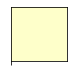

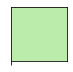

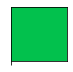

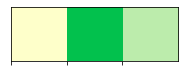

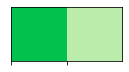

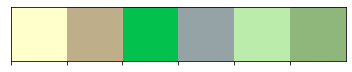

In [6]:
import config_plot as cp

#  Functions

In [7]:
def get_cell_lines(cl):
    sample_dict = {
    cl: f"ELS_combined_{cl}",
    }

    return sample_dict


def get_paths(cell_line, file_tag, fantombase, encodepath):

    FANTOMPATH = os.path.join(fantombase, file_tag, "ages")
    FANTOMFILE = "syn_breaks_%s_ages.bed" % file_tag
    FANTOM = os.path.join(FANTOMPATH, FANTOMFILE)

    if "CL" in cell_line:
        ENCODEFILE = "cells/" + cell_line.split("_CL")[0] + ".bed.gz"
    elif cell_line == "all_fantom_enh":
        ENCODEFILE = "trimmed_encRegTfbsClusteredWithCells.bed"
    else:
        ENCODEFILE = "cells/" + cell_line + ".bed.gz"

    ENCODE = os.path.join(encodepath, ENCODEFILE)


    INTERSECTIONPATH = os.path.join(fantombase, file_tag)
    INTERSECTIONFILE = "%s_x_ENCODE.bed" % file_tag
    INTERSECTION = os.path.join(INTERSECTIONPATH, INTERSECTIONFILE)

    return FANTOM, ENCODE, INTERSECTION


def bed_intersect(fantom, encode, intersection):

    if os.path.exists(intersection) is False:
        cmd = f"bedtools intersect -a {fantom} -b {encode} -wao > {intersection}"

        subprocess.call(cmd, shell = True)

        print(cmd)
    else:
        print("previously done enh x encode intersection")


def get_core_age(df):
    core = df.groupby("enh_id")["mrca_2"].max().reset_index()
    core.columns = ["enh_id", 'core_mrca_2']
    df = pd.merge(df, core, how = "left")

    return df


def reEval_PrimComplex(enh):

    # get all the complex enhancers w/ primate core ages
    prComEnhID = enh.loc[(enh.core ==1) &
    (enh.core_remodeling ==1) &
    (enh.taxon2.str.contains("Primate"))]["enh_id"].unique()

    # get all the complex enhancer ids where there is a real human derived sequence
    pr_complex = enh.loc[(enh.enh_id.isin(prComEnhID)) &
    (enh.core_remodeling == 1) &
    (enh.core ==0) &
    (enh.mrca ==0),
    ]["enh_id"]


    # i'm going to reassign any primate complex enhancer
    # where derived regions are from other primates
    # get the set of primate complex enhancers w/ primate derived sequences
    # and rename them as simple enhancers
    pr_simple = set(prComEnhID) - set(pr_complex)

    # reassign core and core remodeling columns
    enh.loc[enh.enh_id.isin(pr_simple), "core"] = 1
    enh.loc[enh.enh_id.isin(pr_simple), "core_remodeling"] = 0
    return enh

def format_df(intersection_file):

    cols = ["chr_syn", "start_syn", "end_syn",
    "enh_id","chr", "start", "end",
    "seg_index", "core_remodeling", "core",
    "mrca",
    "chr_tf", "start_tf", "end_tf",
    "tf_id", "peak_len",
    "tf", "cell_line" , "overlap"
    ]

    df = pd.read_csv(intersection_file,
    sep = '\t',
    header = None).drop_duplicates()

    df.columns = cols # add column names

    df["tf"] = df["tf_id"].apply(lambda x: x.split("_")[0])

    # add architecture label - core, derived, simple
    df["arch"] = "simple"
    df.loc[(df.core_remodeling ==1) & (df.core ==1), "arch"] = "complex_core"
    df.loc[(df.core_remodeling ==1) & (df.core ==0), "arch"] = "complex_derived"

    # add architecture label - complex, simple
    df["overallarch"] = "simple"
    df.loc[df.core_remodeling ==1, "overallarch"] = "complex"

    # add syn identifier
    df["syn_id"] = df.chr_syn + ":" + df.start_syn.map(str) + "-" + df.end_syn.map(str)

    #calculate enhancer and syntenic block length
    df["enh_len"] = df.end - df.start
    df["syn_len"] = df.end_syn - df.start_syn
    df.loc[df.syn_len <6, "syn_len"] = 0


    # binary for TF overlap, any TF that overlaps less than 6bp is not counted.
    df["tfoverlap_bin"] = 1
    df.loc[df.tf == ".", "tfoverlap_bin"] = 0
    df.loc[df.overlap <6 , "tfoverlap_bin"] = 0

    return df


def just_get_df(cell_line, val, fantombase, encodepath,):
    print(cell_line, val)
    fantom, encode, intersection = get_paths(cell_line, val, fantombase, encodepath)

    #Bed command
    bed_intersect(fantom, encode, intersection)

    #dataframe
    df = format_df(intersection)

    return df


def count_enhancers(df, arch):

    if arch == "enh":
        enh_df = df.groupby(["enh_id", "core_remodeling", "overallarch"])[["mrca", "seg_index"]].max().reset_index()

        totalenh_n = len(enh_df) #30279 enhancers total
        simpleenh_n = len(enh_df.loc[enh_df.overallarch == "simple"]) #14098 simple enhancers
        complexenh_n = len(enh_df.loc[enh_df.overallarch != "simple"]) # 8744 complex enhancers


        return totalenh_n, simpleenh_n, complexenh_n

    elif arch == "syn":

        total = len(df)
        core_n = df.loc[df.arch == "complex_core"]["syn_id"].count()
        derived_n = df.loc[df.arch == "complex_derived"]["syn_id"].count()
        simple_n = df.loc[df.arch == "simple"]["syn_id"].count()

        return total, core_n, derived_n, simple_n


def mwu(tf_density, arch):

    # calculate means
    median = (tf_density.groupby("arch")["tf_density"].median())
    print("\narchitecture medians", median)

    if arch == "enh":

        #stratify dataframe by simple and complex arch
        simple_tfden = tf_density.loc[tf_density.arch == "simple", "tf_density"]
        complex_tfden = tf_density.loc[tf_density.arch == "complex", "tf_density"]

        # calculate MWU
        test_arch, p_arch = stats.mannwhitneyu(simple_tfden, complex_tfden)
        print("\n", "simple v. complex enh MWU stat =", round(test_arch,3), "p =", p_arch )

        return test_arch, p_arch, median

    elif arch == "syn":

        simple_tfden = tf_density.loc[tf_density.arch == "simple", "tf_density"]
        core_tfden = tf_density.loc[tf_density.arch == "complex_core", "tf_density"]
        derived_tfden = tf_density.loc[tf_density.arch == "complex_derived", "tf_density"]

        testcore, pcore = stats.mannwhitneyu(simple_tfden, core_tfden)
        print("\n", "simple v. complexcore MWU stat =", round(testcore,3), "p =", pcore)

        test_der, p_der = stats.mannwhitneyu(derived_tfden, core_tfden)
        print("\n", "core v. derived MWU stat =", round(test_der,3), "p =", p_der)

        return testcore, pcore, test_der, p_der, median


def calculate_tf_density(arch, df):

    density_cols = ["id", "len", "arch", "tfoverlap_bin", "tf_density",]


    if arch == "enh":

        tf_density = df.groupby(["enh_id", "enh_len", "overallarch"])["tfoverlap_bin"].sum().reset_index().drop_duplicates()
        tf_density["tf_density"] = tf_density["tfoverlap_bin"].divide(tf_density.enh_len)


    elif arch == "syn":

        tf_density = df.groupby(["syn_id", "syn_len", "arch"])["tfoverlap_bin"].sum().reset_index()
        tf_density["tf_density"] = tf_density["tfoverlap_bin"].divide(tf_density.syn_len)

    # rename columns
    tf_density.columns = density_cols

    # how many enhancers do not overlap  TFs?
    zero_overlap = tf_density.loc[tf_density.tfoverlap_bin == 0].groupby("arch")["id"].count().reset_index()

    return tf_density, zero_overlap


def calculate_zero_syn_freq(zero_syn, df, cell_line, RE):

    zero_syn.columns = ['arch', "zero_counts"]

    arch_df = df[["arch", "syn_id"]].drop_duplicates()

    total_arch_counts = arch_df.groupby(["arch"])["syn_id"].count().reset_index()
    total_arch_counts.columns = ['arch', "total_counts"]

    zero_syn = pd.merge(zero_syn, total_arch_counts, on = "arch")
    zero_syn["freq_zero"] = zero_syn.zero_counts.divide(zero_syn.total_counts)
    zero_syn["freq_nonzero"] = 1-zero_syn["freq_zero"]

    print(zero_syn)
    zero_syn.to_csv('%snonzero_%s.csv' % (RE, cell_line), index = False)


def plot_bar_tf_density(x, y, data, outf, order, p, med):

    # plot enhancer TF density
    fig, ax = plt.subplots(figsize = (6,6))
    sns.set("poster")

    sns.barplot(x, y, data = data, estimator = np.median,
    order = order, palette = yg, n_boot = 10000)

    ax.set(
    xlabel= "p = %s\n%s" % (p,med),
    title = outf.split("/")[-1],
    ylabel = "TFBS density\nmedian"
    )

    plt.savefig(outf, bbox_inches = 'tight')


def add_syn_age_annotation(syn_to_merge):
    SYN_GROUP = "/dors/capra_lab/projects/enhancer_ages/hg38_syn_taxon.bed"
    syn = pd.read_csv(SYN_GROUP, sep = '\t')

    # round all values

    syn[["mrca", "mrca_2"]] = syn[["mrca", "mrca_2"]].round(3)
    syn_to_merge.mrca = syn_to_merge.mrca.round(3)

# do the dance - add mrca_2 column, get mrca_2 core age, drop mrca_2 column, then add it back, but this time to reflect the core_age and core taxon, instead of the syntenic age.
    syn_merged = pd.merge(syn_to_merge, syn[["mrca", "mrca_2"]], how = "left")

    return syn_merged, syn


def make_pdf(file_name, RE):

    OUTFILE = file_name + ".pdf"
    OUTF = os.path.join(RE, OUTFILE)

    return OUTF



def prep_2x2(tf, arch1, arch2, df):

    # only evaluate enhancers that overlap TF.
    # This excludes enhancers with zero overlaps from background set.
    df = df.loc[df.tfoverlap_bin >0]

    # split dataframe by two architectures to compare
    dfarch = df.loc[df.arch == arch1]

    if arch2 == "bkgd":
        arch2 = "all_enh_bkgd"
        dfbkgd = df.loc[df.arch != arch1]

    else:
        dfbkgd = df.loc[df.arch == arch2]

    comparison_name = tf + "-" + arch1 + "_v_" + arch2

    # count how many TF overlaps are in each arch.
    TF_in_arch = len(dfarch.loc[dfarch.tf == tf])
    TF_bkgd = len(dfbkgd.loc[dfbkgd.tf == tf])
    not_TF_in_arch = len(dfarch.loc[dfarch.tf != tf])
    not_TF_in_bkgd = len(dfbkgd.loc[dfbkgd.tf != tf])

    a, b, c, d = TF_in_arch, not_TF_in_arch, TF_bkgd, not_TF_in_bkgd


    checkrowone = a + b

    if checkrowone > 0:
        obs = [[a,b], [c,d]]

        return obs, comparison_name
    else:
        print("no obs for", tf)

        obs = [[0,0], [0,0]]

        return obs, comparison_name


def quantify_2x2(obs, comparison_name, min_instances):

    if obs[0][0] > min_instances or obs[1][0]>min_instances:

        OR, P = stats.fisher_exact(obs)
        table = sm.stats.Table2x2(obs) # get confidence interval
        odds_ci = table.oddsratio_confint()
        newdf = pd.DataFrame({"comparison_name":comparison_name,
                              "a":obs[0][0], "b":obs[0][1],
                              "c":obs[1][0], "d":obs[1][1],
                              "OR":[OR], "P":[P],
                              "ci_lower" :[odds_ci[0]],
                              "ci_upper" :[odds_ci[1]],
                            })
    else:
        newdf = pd.DataFrame() # return empty dataframe


    return newdf


def fdr_correction(collection_dict, alpha):

    df = pd.concat(collection_dict.values())

    pvals = df["P"]

    df["reject_null"], df["FDR_P"] = statsmodels.stats.multitest.fdrcorrection(pvals, alpha=alpha)

    # other dataframe formatting
    df["arch"] = df["comparison_name"].apply(lambda x: x.split("-")[1])
    df["tf"] = df["comparison_name"].apply(lambda x: x.split("-")[0])
    df["log2"]= np.log2(df["OR"])

    return df


def plot_bar_tf_enrichment(df, cell_line, outf, alpha, taxon2):

    fig, ax = plt.subplots(figsize = (6,12))
    sns.set("poster")

    x = "tf"
    y = "log2"
    hue = "arch"
    data = df.sort_values(by = y)

    sns.barplot(x=y, y=x, data=data , hue = hue, palette = config.stemg)

    ax.legend(bbox_to_anchor = (1,1))

    if taxon2 !=None:
        label = cell_line + "_" + taxon2
    else:
        label = cell_line

    ax.set(xlabel = "OR log2-scale\n FDR<%s" % str(alpha), title = label)

    plt.savefig(outf, bbox_inches = "tight")


def run_2x2(arch1, arch2, df, min_instances, alpha, taxon2):

    collection_dict = {}

    for tf in df.tf.unique():

        if tf != ".":

            obs, comparison_name = prep_2x2(tf, arch1, arch2, df)

            results = quantify_2x2(obs, comparison_name, min_instances)

            if results.empty ==False:
                collection_dict[comparison_name] = results

    #FDR correction
    if len(collection_dict) > 0: # if there are any results

        results_df = fdr_correction(collection_dict, alpha)

        df = results_df.loc[results_df.reject_null == True]


        if len(df)>0: # if there are any significant results, plot them!

            if taxon2 != None:
                outf = make_pdf("%s_enh_x_encode3_sig_tf_arch_enrichment_%s_v_%s_FDR_%s_%s" % (cell_line, arch1, arch2, alpha, taxon2), RE)
                #plot_bar_tf_enrichment(df, cell_line, outf, alpha, taxon2)

            else:
                outf = make_pdf("%s_enh_x_encode3_sig_tf_arch_enrichment_%s_v_%s_FDR_%s" % (cell_line, arch1, arch2, alpha), RE)
                #plot_bar_tf_enrichment(df, cell_line, outf, alpha, taxon2)

            return results_df

        else:
                print("\nno sig results for comparison", arch1, "v.", arch2, "in", taxon2)

    else:
        print("\nnot any results for comparison", arch1, "v.", arch2, "in", taxon2)

In [8]:
def run_analysis(cell_line, val, fantombase, encodepath, min_instances, alpha):

    print(cell_line, val)
    fantom, encode, intersection = get_paths(cell_line, val, fantombase, encodepath)
    print(fantom, encode, intersection)
    #Bed command
    bed_intersect(fantom, encode, intersection)

    #dataframe
    df = format_df(intersection)

    #get some basic info about Fantom enhancer overlap
    arch = "enh"
    totaln, simplen, complexn = count_enhancers(df, arch)

    # calculate enhancer TF density
    tf_density_enh, zero_enh = calculate_tf_density(arch, df)


    # plot all enhancer-level data
    x, y = "arch", "tf_density"
    order = ["simple", "complex"]

    data = tf_density_enh
    outf = make_pdf("%s_enh_x_encode3_tf_density_%s"  % (cell_line, arch), RE)

    test_arch, p_arch, median = mwu(tf_density_enh, arch)
    plot_bar_tf_density(x, y, data, outf, order, p_arch, median)


    print("\nNon-zero TFBS densities only")


    # plot all enhancer-level data without zeros
    non_zero_tf_density = tf_density_enh.loc[tf_density_enh.tfoverlap_bin>0]

    data = non_zero_tf_density
    outf = make_pdf("%s_enh_x_encode3_tf_density_%s_non_zero_tf_density" % (cell_line, arch), RE)
    test_arch_, p_arch_, median = mwu(non_zero_tf_density, arch)
    plot_bar_tf_density(x, y, data, outf, order, p_arch_, median)



    # calculate syn-level TF density
    arch = "syn"
    totaln, coren, derivedn, simplen = count_enhancers(df, arch)
    tf_density_syn, zero_syn = calculate_tf_density(arch, df)

    # calculate frequency of derived sequences that do not overlap TFBS

    calculate_zero_syn_freq(zero_syn, df, cell_line, RE)

    print("\nSyn TFBS densities")
    # plot syn block TF density
    order = ["simple", "complex_core", "complex_derived"]
    data = tf_density_syn
    outf = make_pdf("%s_enh_x_encode3_tf_density_%s" % (cell_line, arch), RE)

    testcore, pcore, test_der, p_der, median = mwu(tf_density_syn, arch)
    new_p = "simple_v_core p = %s,  core_v_der= %s" %(pcore, p_der)
    plot_bar_tf_density(x, y, data, outf, order, new_p, median)


    print("\nNon-zero syn TFBS densities only")
    non_zero_syn_tf_density = tf_density_syn.loc[tf_density_syn.tfoverlap_bin>0]


    # plot non-zero syn block TF density
    data = non_zero_syn_tf_density
    outf = make_pdf("%s_syn_x_encode3_tf_density_%s_non_zero_tf_density" % (cell_line, arch), RE)

    testcore, pcore, test_der, p_der, median = mwu(non_zero_syn_tf_density, arch)
    new_p = "simple_v_core p = %s,  core_v_der= %s" %(pcore, p_der)
    plot_bar_tf_density(x, y, data, outf, order, new_p, median)


    ### TF ENRICHMENT IN ARCHITECTURE ###
    # DER V. CORE
    # DER V. BKGD

    # calculate TF enrichment in architecture/syn blocks
    arch1, arch2 = "complex_derived", "complex_core"
    der_v_core = run_2x2(arch1, arch2, df, MIN_INSTANCES, ALPHA, None)

    arch1, arch2 = "complex_derived", "bkgd"
    der_v_bkgd = run_2x2(arch1, arch2, df, MIN_INSTANCES, ALPHA, None)

    arch1, arch2 = "simple", "complex_core"
    simple_v_core = run_2x2(arch1, arch2, df, MIN_INSTANCES, ALPHA, None)

    arch1, arch2 = "simple", "bkgd"
    simple_v_bkgd = run_2x2(arch1, arch2, df, MIN_INSTANCES, ALPHA, None)

    arch1, arch2 = "simple", "complex_derived"
    simple_v_der = run_2x2(arch1, arch2, df, MIN_INSTANCES, ALPHA, None)

    arch1, arch2 = "complex_core", "bkgd"
    core_v_bkgd = run_2x2(arch1, arch2, df, MIN_INSTANCES, ALPHA, None)

    return der_v_core, der_v_bkgd, tf_density_enh, tf_density_syn, simple_v_core, simple_v_bkgd, simple_v_der, core_v_bkgd, df

In [9]:
def lump_taxons(df):
    # lump small samples with larger, older ancestors
    df.loc[df.taxon2 == "Sarcopterygian", "taxon2"] = "Vertebrata"
    df.loc[df.taxon2 == "Tetrapoda", "taxon2"] ="Vertebrata"
    df.loc[df.taxon2 == "Euarchontoglires", "taxon2"] = "Boreoeutheria"

    return df

In [39]:
def get_counts(df, groupby_cols, groupby_val):

    counts = df.groupby(groupby_cols)[groupby_val].sum().reset_index()

    if "mrca_2" in groupby_cols and "core_remodeling" in groupby_cols:

        empty = make_empty_dict(info_df) # make an empty df to fill architectures w/ no counts
        counts = pd.merge(empty, counts, how = "left", on = groupby_cols).fillna(0)

    elif "core_mrca_2" in groupby_cols and "core_remodeling" in groupby_cols:

        empty = make_empty_dict(info_df) # make an empty df to fill architectures w/ no counts
        empty.columns = ["core_mrca_2", "core_remodeling"]
        counts = pd.merge(empty, counts, how = "left", on = groupby_cols).fillna(0)
        #counts = pd.concat([counts, empty]) # concat the dataframe

    # change count data to int
    counts[groupby_val] = counts[groupby_val].astype(int)

    # sort and reset the index. Seaborn plots by index value.
    counts = counts.sort_values(by = groupby_cols).reset_index()

    # drop the index column.
    counts = counts.drop(["index"], axis = 1)

    return counts


def plot_annotate_counts(splot, counts_df, groupby_val, height_adjust):

    # annotate plot with counts
    for n, p in enumerate(splot.patches):

        value = counts_df.iloc[n][groupby_val].astype(int)
        #print(n, p, value)
        if height_adjust == 0:
            height_adjust = (p.get_height()-0.03)


        splot.annotate(value,
                       (p.get_x() + p.get_width() / 2.,height_adjust),
                       ha = 'center', va = 'baseline',
                       size=15,
                       rotation = 90,
                       color = "k",
                       xytext = (0, 1),
                       textcoords = 'offset points'
                       )
        
def make_empty_dict(df):
    # for when i need an empty dictionary with a complete set of architectures and values
    emptydf_dict = {}
    val = 0 # unique identifier
    for mrca_2 in df.mrca_2.unique():
        for arch in df.arch.unique():

            emptydf = pd.DataFrame({ "mrca_2":[mrca_2], "arch":[arch],})
            emptydf_dict[val] = emptydf
            val+=1
    empty = pd.concat(emptydf_dict.values())
    return empty

In [11]:
def plot_stratified_age(act_df, outf, x, cell_model):

    y = "activity"
    hue = "arch"
    data = act_df
    order = ["core", "complex_core", "complex_derived"]


    fig, ax = plt.subplots(figsize = (6,6))
    #fig, ax = plt.subplots()
    sns.set("poster")

    splot = sns.barplot(x = x,
    y = y,
    data = data,
    hue = hue,
    hue_order = order,
    palette = palette
    )
    labs = ["Homo", "Prim", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Vert"]
    ax.set(
        #ylim = (0,0.02),
        title = cell_model)
    
    ax.set_xticklabels(labs, rotation = 90)
    
    ax.invert_xaxis()
    height_adjust = 0.001

    groupby_cols, groupby_val = ["core_remodeling", x], "counts"
    countdf = get_counts(act_df, groupby_cols, groupby_val)

    plot_annotate_counts(splot, countdf, groupby_val, height_adjust)
    ax.legend(bbox_to_anchor = (1,1))

    plt.savefig(outf, bbox_inches = "tight")
    return countdf


def plot_distplot(df, cell_model, matching):
    sns.distplot(df.loc[df.arch == "complex_core", "syn_len"], label = "core")
    sns.distplot(df.loc[df.arch == "complex_derived", "syn_len"], label = "der")
    plt.legend()
    outf =  f"{RE}{cell_model}_ernst_active_bases_dist_{matching}.pdf"
    plt.savefig(outf, bbox_inches = "tight")

# Get dataframe 

In [12]:
#%% make a dictionary of the cell lines
sample_dict = get_cell_lines(CL)

In [13]:
#%% Load the dataframe

val = f"ELS_combined_{CL}"
df = just_get_df(CL, val, ENHBASE, ENCODEPATH)
df.head()

K562 ELS_combined_K562
previously done enh x encode intersection


,chr_syn,start_syn,end_syn,enh_id,chr,start,end,seg_index,core_remodeling,core,...,peak_len,tf,cell_line,overlap,arch,overallarch,syn_id,enh_len,syn_len,tfoverlap_bin
0,chr1,100036809,100037123,chr1:100036809-100037123,chr1,100036809,100037123,0,0,1,...,396,MAX,K562,30,simple,simple,chr1:100036809-100037123,314,314,1
1,chr1,100036809,100037123,chr1:100036809-100037123,chr1,100036809,100037123,0,0,1,...,540,HDAC1,K562,30,simple,simple,chr1:100036809-100037123,314,314,1
2,chr1,100036809,100037123,chr1:100036809-100037123,chr1,100036809,100037123,0,0,1,...,430,CBX3,K562,20,simple,simple,chr1:100036809-100037123,314,314,1
3,chr1,100036809,100037123,chr1:100036809-100037123,chr1,100036809,100037123,0,0,1,...,596,ZNF24,K562,30,simple,simple,chr1:100036809-100037123,314,314,1
4,chr1,100036809,100037123,chr1:100036809-100037123,chr1,100036809,100037123,0,0,1,...,280,JUND,K562,30,simple,simple,chr1:100036809-100037123,314,314,1


# get rid of non-complex enhancers (i.e. enhancers < 6bp syntenic lengths)


In [14]:
def confirm_complex(df):
    # get all enhancers w/ syn_lengs > 5 bp
    cleaning = df.loc[df.syn_len>5].groupby(["enh_id", "core_remodeling", "core"])["arch"].count().reset_index()
    
    # count how many syntenic regions belong to each core, derived, simple 
    complex_check = cleaning.groupby(["enh_id", "core_remodeling"])["core"].count().reset_index()

    # count the number of complex enhancers that no longer have 2 regions (core, derived)
    not_complex_ids = complex_check.loc[(complex_check["core_remodeling"]== 1) 
                  &(complex_check["core"] <2), "enh_id"]
    
    return not_complex_ids

In [15]:
blacklist =  confirm_complex(df)

In [16]:
# remove all the enhancers
df = df.loc[~df["enh_id"].isin(blacklist)]

# Analysis  of Zeros and non-zeros

### count overlaps per SUMMED core, derived, simple 

In [17]:
test = df.groupby(["enh_id", "core_remodeling", "core"])["tfoverlap_bin"].max().reset_index()

In [18]:
counts = test.groupby(
    ["core_remodeling", "core", "tfoverlap_bin"]
    )["enh_id"].count().reset_index()
counts

,core_remodeling,core,tfoverlap_bin,enh_id
0,0,1,0,1379
1,0,1,1,20827
2,1,0,0,4028
3,1,0,1,16159
4,1,1,0,3112
5,1,1,1,17075


### how many derived, core, simple regions bind TFBS? 

In [19]:
simple = counts.loc[counts["core_remodeling"] == 0]
core = counts.loc[(counts["core_remodeling"] == 1)& (counts["core"]==1)]
der = counts.loc[counts["core"]==0]

print("non-zero der", der.loc[der["tfoverlap_bin"] ==1, "enh_id"].iloc[0]/der["enh_id"].sum())
print("non-zero core", core.loc[core["tfoverlap_bin"] ==1, "enh_id"].iloc[0]/core["enh_id"].sum())
print("non-zero simple",  simple.loc[simple["tfoverlap_bin"] ==1, "enh_id"].iloc[0]/simple["enh_id"].sum())

non-zero der 0.8004656462079556
non-zero core 0.8458413830683112
non-zero simple 0.9378996667567324


### How many total

In [20]:
# complex, simple
der["enh_id"].sum(), core["enh_id"].sum(), simple["enh_id"].sum()

(20187, 20187, 22206)

### how many enhancers lack TFBS in BOTH core and derived? 
3222 simple and 2990 complex enhancers have NO evidence of TFBS binding. 

In [21]:
any_zero = test.groupby(["enh_id", "core_remodeling"])["tfoverlap_bin"].max().reset_index() # groupby by complex simple (not core derived) and evaluate n TFBS overlap
both_zero = any_zero.loc[any_zero["tfoverlap_bin"] ==0, "enh_id"]
any_zero.groupby(["core_remodeling", "tfoverlap_bin"])["enh_id"].count().reset_index()

,core_remodeling,tfoverlap_bin,enh_id
0,0,0,1379
1,0,1,20827
2,1,0,1095
3,1,1,19092


### removing enhancers that do not bind TFBS (simple or in both core/derived regions) , how many enhancers regions have no TFBS??

in other words, a TFBS must bind the enhancer. If a region has no evidence for binding, is it a core or derived region? 

In [22]:
counts_ = test.loc[~test.enh_id.isin(both_zero)].groupby(
    ["core_remodeling", "core", "tfoverlap_bin"]
    )["enh_id"].count().reset_index()

In [23]:
simple = counts_.loc[counts_["core_remodeling"] == 0]
core = counts_.loc[(counts_["core_remodeling"] == 1)& (counts_["core"]==1)]
der = counts_.loc[counts_["core"]==0]

print("non-zero der", der.loc[der["tfoverlap_bin"] ==1, "enh_id"].iloc[0]/der["enh_id"].sum())
print("non-zero core", core.loc[core["tfoverlap_bin"] ==1, "enh_id"].iloc[0]/core["enh_id"].sum())
print("non-zero simple",  simple.loc[simple["tfoverlap_bin"] ==1, "enh_id"].iloc[0]/simple["enh_id"].sum())

non-zero der 0.8463754452126545
non-zero core 0.8943536559815629
non-zero simple 1.0


## get some basic info about enhancer landscapes (simple v. complex), overlap with TFBS

### Syntenic-block level

In [24]:
arch = "enh"
totaln, simplen, complexn = count_enhancers(df, arch)
totaln, simplen, complexn

(42393, 22206, 20187)

In [25]:
# calculate enhancer TF density
tf_density_enh, zero_enh = calculate_tf_density(arch, df)
zero_enh.id.sum()

2474

## ZERO TABLE

In [26]:
# get some basic infor about syntenic landscapes (simple v. core v. derived),
arch = "syn"
totaln, coren, derivedn, simplen = count_enhancers(df, arch) # count the total n syntenic regions
tf_density_syn, zero_syn = calculate_tf_density(arch, df)  # calculate tfbs density w and w/o zeros
calculate_zero_syn_freq(zero_syn, df, CL, RE)


tf_density_syn.head()

              arch  zero_counts  total_counts  freq_zero  freq_nonzero
0     complex_core         5731         26728   0.214419      0.785581
1  complex_derived        16572         40110   0.413164      0.586836
2           simple         1587         22768   0.069703      0.930297


,id,len,arch,tfoverlap_bin,tf_density
0,chr10:100185328-100185374,46,complex_derived,0,0.0
1,chr10:100185374-100185411,37,complex_derived,0,0.0
2,chr10:100185411-100185419,8,complex_derived,0,0.0
3,chr10:100185419-100185506,87,complex_core,0,0.0
4,chr10:100185506-100185507,0,complex_derived,0,NaN


In [27]:
#%% evaluate the non-zero syntenic blocks only.

non_zero_syn_tf_density = tf_density_syn.loc[tf_density_syn.tfoverlap_bin>0]
non_zero_syn_tf_density.groupby("arch")["tf_density"].median()

testcore, pcore, test_der, p_der, median = mwu(non_zero_syn_tf_density, arch)


architecture medians arch
complex_core       0.061947
complex_derived    0.074627
simple             0.046512
Name: tf_density, dtype: float64

 simple v. complexcore MWU stat = 191530371.5 p = 1.2685025117387805e-134

 core v. derived MWU stat = 226291873.0 p = 1.2190397518136607e-53


## get ages for core, derived, simple regions

In [28]:
#%% Let's group the dataframe to get syntenic blocks and their TFBS overlap.

syn_ages = df.groupby(["enh_id","syn_id", "syn_len", "arch", "mrca"])["tfoverlap_bin"].sum().reset_index()
syn_ages.head()

,enh_id,syn_id,syn_len,arch,mrca,tfoverlap_bin
0,chr10:100185328-100185532,chr10:100185328-100185374,46,complex_derived,0.190,0
1,chr10:100185328-100185532,chr10:100185374-100185411,37,complex_derived,0.606,0
2,chr10:100185328-100185532,chr10:100185411-100185419,8,complex_derived,0.190,0
3,chr10:100185328-100185532,chr10:100185419-100185506,87,complex_core,0.867,0
4,chr10:100185328-100185532,chr10:100185506-100185507,0,complex_derived,0.756,0


## do some age formatting, get core ages

In [29]:
syn_ages, syn = add_syn_age_annotation(syn_ages) # add MRCA_2 annotations

syn_ages = get_core_age(syn_ages) # annotate core ages for each syntenic block.

syn_ages = syn_ages.rename(columns = {"mrca_2":"syn_mrca_2"})# rename column, preserve the mrca_2 annotation per syntenic block

# add core_mrca_2 taxon annotations
syn_ages = pd.merge(syn_ages, syn[["mrca_2", "taxon2"]], how = "left",
                    left_on = "core_mrca_2", right_on = "mrca_2")

# include only the values greater than 5
syn_ages = syn_ages.loc[syn_ages.syn_len >5]

# make a boolean for TFBS overlapping syntenic block
syn_ages["tfbs_bool"] = False
syn_ages.loc[syn_ages.tfoverlap_bin >0, "tfbs_bool"] = True

In [30]:
#%% # evaluate zeros as a fraction of the total architecture

zeros_only = syn_ages.loc[syn_ages.tfoverlap_bin ==0]

gz = zeros_only.groupby(["syn_mrca_2", "arch"])["enh_id"].count().reset_index()

gz.columns = ["syn_mrca_2", "arch", 'mrca_zero_counts']

totals = syn_ages.groupby(["arch"])["enh_id"].count().reset_index()
totals.columns = ["arch", "total_arch"]

gz = pd.merge(gz, totals, how = "left")
gz["frac_of_arch"] = gz.mrca_zero_counts.divide(gz.total_arch)
gz.head()

,syn_mrca_2,arch,mrca_zero_counts,total_arch,frac_of_arch
0,0.000,complex_derived,25,32884,0.000760
1,0.144,complex_core,24,26291,0.000913
2,0.144,complex_derived,855,32884,0.026000
3,0.144,simple,2136,40969,0.052137
4,0.146,complex_core,43,26291,0.001636


## evaluate % regions w/ zero overlap across entire region set 
##### BIASED BY DIFFERENT NUMBERS OF ENHANCERS PER AGE, BETTER TO DO WITHIN AGE % PER CORE, DERIVED, SIMPLE

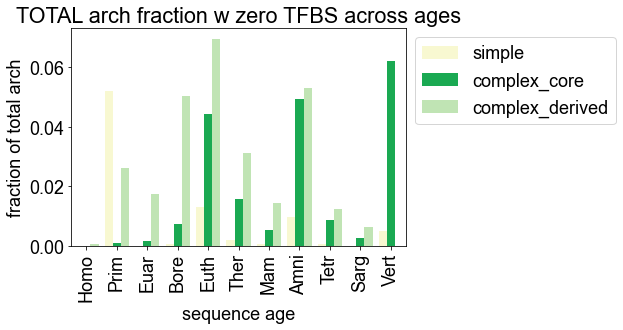

In [31]:
#%% plot
xlabs = ["Homo", "Prim", "Euar", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Sarg", "Vert"]

x, y ="syn_mrca_2", "frac_of_arch"

hue_order = ["simple", "complex_core", "complex_derived"]

fig, ax = plt.subplots()

sns.barplot(data = gz, x= x, y=y, hue = "arch",
            hue_order = hue_order, palette = cp.yg)

ax.set_xticklabels(xlabs, rotation = 90)
ax.set(xlabel = "sequence age",
ylabel = "fraction of total arch",
title = "TOTAL arch fraction w zero TFBS across ages")

ax.legend(bbox_to_anchor = (1,1))

## plot within age frequency of zeros

In [32]:
#%% evaluate zeros as a fraction of the architecture per age

totals_mrcas = syn_ages.groupby(["syn_mrca_2", "arch"])["enh_id"].count().reset_index()
totals_mrcas.columns = ["syn_mrca_2", "arch", "mrca_counts"]

totals_mrcas = pd.merge(totals_mrcas, gz)

totals_mrcas["frac_zero_mrca"] = totals_mrcas.mrca_zero_counts.divide(totals_mrcas.mrca_counts)
totals_mrcas.head()

,syn_mrca_2,arch,mrca_counts,mrca_zero_counts,total_arch,frac_of_arch,frac_zero_mrca
0,0.000,complex_derived,97,25,32884,0.000760,0.257732
1,0.144,complex_core,128,24,26291,0.000913,0.187500
2,0.144,complex_derived,3154,855,32884,0.026000,0.271084
3,0.144,simple,20848,2136,40969,0.052137,0.102456
4,0.146,complex_core,179,43,26291,0.001636,0.240223


In [43]:
totals_mrcas = totals_mrcas.rename(columns = {"syn_mrca_2": "mrca_2"})
empty = make_empty_dict(totals_mrcas)
totals_mrcas = pd.merge(empty, totals_mrcas, how = "left" ).fillna(0)

### for plotting annotations, add an order column

In [54]:
totals_mrcas["order"] = 0
totals_mrcas.loc[totals_mrcas["arch"].str.contains("core"), "order"] = 1
totals_mrcas.loc[totals_mrcas["arch"].str.contains("derived"), "order"] = 2
totals_mrcas.sort_values(by=["order", "mrca_2",])

,mrca_2,arch,mrca_counts,mrca_zero_counts,total_arch,frac_of_arch,frac_zero_mrca,order
2,0.000,simple,0.0,0.0,0.0,0.000000,0.000000,0
5,0.144,simple,20848.0,2136.0,40969.0,0.052137,0.102456,0
8,0.146,simple,86.0,3.0,40969.0,0.000073,0.034884,0
11,0.167,simple,460.0,31.0,40969.0,0.000757,0.067391,0
14,0.190,simple,8332.0,531.0,40969.0,0.012961,0.063730,0
17,0.425,simple,1258.0,76.0,40969.0,0.001855,0.060413,0
20,0.497,simple,281.0,20.0,40969.0,0.000488,0.071174,0
23,0.606,simple,6057.0,394.0,40969.0,0.009617,0.065049,0
26,0.656,simple,278.0,21.0,40969.0,0.000513,0.075540,0
29,0.756,simple,51.0,2.0,40969.0,0.000049,0.039216,0


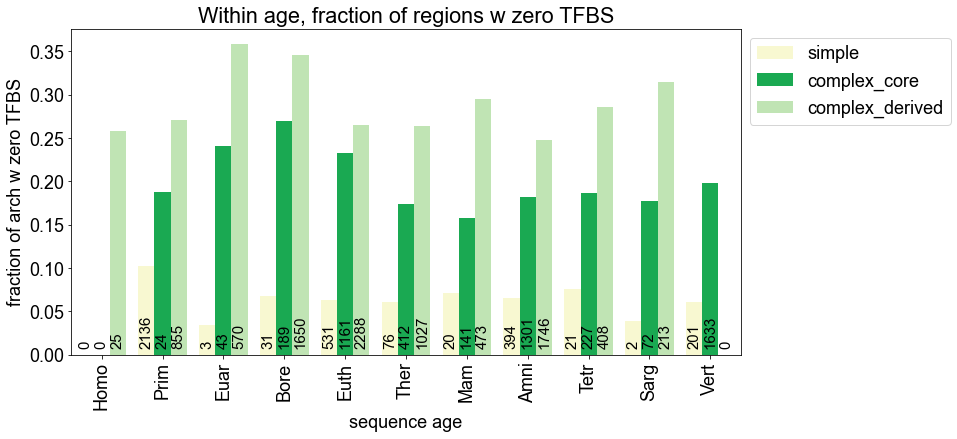

In [59]:
#%%
xlabs = ["Homo", "Prim", "Euar", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Sarg", "Vert"]

hue_order = ["simple", "complex_core", "complex_derived"]

x, y ="mrca_2", "frac_zero_mrca"
fig, ax = plt.subplots(figsize = (12,6))
splot = sns.barplot(data = totals_mrcas, x= x, y=y, hue = "arch",
            hue_order = hue_order, palette = cp.yg)

ax.set_xticklabels(xlabs, rotation = 90)

ax.set( xlabel = "sequence age",
        ylabel = "fraction of arch w zero TFBS",
        title = "Within age, fraction of regions w zero TFBS")


height_adjust = 0.01

plot_annotate_counts(splot, totals_mrcas.sort_values(by=["order", "mrca_2"]), "mrca_zero_counts", height_adjust)

ax.legend(bbox_to_anchor = (1,1))
#plt.xticks(xlabs, xlabs[::-1])

outf = f"{RE}zero_frac_per_mrca.pdf"
plt.savefig(outf, bbox_inches = "tight")

In [60]:
RE

'/dors/capra_lab/projects/enhancer_ages/landscape/results/cCRE_x_tfbs_encode3/K562/'

In [ ]:
#%%

zeros_only = syn_ages.loc[syn_ages.tfoverlap_bin ==0]

gz = zeros_only.groupby(["core_mrca_2", "arch"])["enh_id"].count().reset_index()

gz.columns = ["core_mrca_2", "arch", 'mrca_zero_counts']

totals = syn_ages.groupby(["arch"])["enh_id"].count().reset_index()
totals.columns = ["arch", "total_arch"]

gz = pd.merge(gz, totals, how = "left")
gz["frac_of_arch"] = gz.mrca_zero_counts.divide(gz.total_arch)
gz.head()
# do the same plot, but with the derived sequences assigned to their core ages.
list(syn_ages)
totals_mrcas = syn_ages.groupby(["core_mrca_2", "arch"])["enh_id"].count().reset_index()
totals_mrcas.columns = ["core_mrca_2", "arch", "mrca_counts"]

totals_mrcas = pd.merge(totals_mrcas, gz)

totals_mrcas["frac_zero_mrca"] = totals_mrcas.mrca_zero_counts.divide(totals_mrcas.mrca_counts)

totals_mrcas = pd.merge(syn_ages[["core_mrca_2", "arch"]], totals_mrcas, how = "left")

syn_ages[["core_mrca_2", "taxon2"]].drop_duplicates()

# calculate odds that TF binds core, derived, simple regions

In [ ]:
xlabs = ["Homo", "Prim", "Euar", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Sarg", "Vert"]

hue_order = ["simple", "complex_core", "complex_derived"]

x, y ="core_mrca_2", "frac_zero_mrca"
fig, ax = plt.subplots()

sns.barplot(data = totals_mrcas, x= x, y=y, hue = "arch",
            hue_order = hue_order, palette = cp.yg)

ax.set_xticklabels(xlabs, rotation = 90)
ax.set( xlabel = "core age",
        ylabel = "fraction of arch w/ zero TFBS",
        title = "fraction of elements that do not bind TFBS, per core age")
ax.legend(bbox_to_anchor = (1,1))
outf = f"{RE}zero_frac_per_core_mrca.pdf"
plt.savefig(outf, bbox_inches = "tight")
#%%
alpha = 0.05

mrca_dict = {}

for arch in syn_ages.arch.unique():
    for mrca_2 in syn_ages.syn_mrca_2.unique():

        in_age = syn_ages.loc[(syn_ages.syn_mrca_2 == mrca_2) & (syn_ages.arch == arch)] # subset to the per age df
        out_age = syn_ages.loc[(syn_ages.syn_mrca_2 != mrca_2) & (syn_ages.arch == arch)] # subset to the per age df
        #print(arch, mrca_2)
        if arch == "complex_derived" and mrca_2 ==0.867:
            continue
        elif arch == "complex_core" and mrca_2 ==0.0:
            continue
        elif arch == "simple" and mrca_2 ==0.0:
            continue
        else:
            ab = in_age.groupby("tfbs_bool")["syn_id"].count().reset_index()
            b,a = ab.iloc[0,1], ab.iloc[1,1]
            cd = out_age.groupby("tfbs_bool")["syn_id"].count().reset_index()
            d,c = cd.iloc[0,1], cd.iloc[1,1]

            obs = [[a,b], [c,d]]

            min_instances = 1
            comparison_name = f"{arch}-{mrca_2}"
            new_df = quantify_2x2(obs, comparison_name, min_instances)
            new_df["mrca_2"] = mrca_2
            new_df["arch"] = arch
            mrca_dict[comparison_name] = new_df


fet_zero_ages = fdr_correction(mrca_dict, alpha) # FDR correction
fet_zero_ages["arch"] = fet_zero_ages.comparison_name.apply(lambda x: x.split("-")[0])
#%%
fet_zero_ages.sort_values(by = "mrca_2")
der_xlabs = xlabs[:-1]
#%%
fet_zero_ages["yerr"]=(fet_zero_ages["ci_upper"] - fet_zero_ages["ci_lower"])
yerrs = fet_zero_ages.pivot(index = "mrca_2", columns = "arch", values = "yerr").fillna(0)

yerrs = yerrs[hue_order]

piv = fet_zero_ages.pivot(index='mrca_2', columns='arch', values='log2')
piv = piv[hue_order].fillna(0)
yerrs

## plot odds that TFBS bind 

In [ ]:
ax = piv.plot(kind='bar',
yerr=yerrs,
figsize = (6,6), #colormap = cp.yg,
#ylabel = "Archs that bind TFs enrichment"
)
ax.set_xticklabels(xlabs)
ax.set(
xlabel = "sequence age",
ylabel = "Archs that bind TFs \nOR enrichment")
outf = f"{RE}FigS_{CL}cCRE_TFBSZeroNonZeroAge.pdf"
plt.savefig(outf, bbox_inches = 'tight')

In [ ]:
#%%

In [ ]:
fig, ax = plt.subplots(figsize = (6,6))
x, y = "mrca_2","log2"
data = fet_zero_ages
hue = "arch"
sns.barplot(x = x, y = y, data = data,
hue = hue, palette = cp.yg, hue_order = hue_order,)
             #yerr= yl)

ax.set(xlabel = "sequence age",
ylabel = "OR architecture binds TF (log2-scaled)",
title = "TFBS enrichment per age, per arch")
ax.set_xticklabels(xlabs)
ax.legend(bbox_to_anchor = (1,1))
outf = f"{RE}FigS5_TF_binding_per_arch_age_fet.pdf"
plt.savefig(outf, bbox_inches = 'tight')